In [1]:
from teneto import TemporalNetwork
import pandas as pd
import pathpy as pp
from tqdm import tqdm
import matplotlib.pyplot as plt
import teneto
import seaborn as sns
import numpy as np
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':200})
sns.set_palette(sns.color_palette('colorblind')[2:])

c:\Users\Bened\Documents\Git\java-package-dependencies-network\.venv\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
df_temp = pd.read_csv("data/df_subviz_temp.csv")

In [4]:
df_temp['t'] = df_temp.t.apply(lambda x: str(x)[:4])
df_temp['t'] = df_temp.t.astype(int)
df_temp['i'] = df_temp.i.astype(str)
df_temp['j'] = df_temp.j.astype(str)
df_temp = df_temp.drop_duplicates().reset_index(drop=True).copy()

In [5]:
names = df_temp.i.tolist()
names.extend(df_temp.j.tolist())
names = list(set(names))
names = {names[i]: i for i in range(len(names))}

yrs = sorted(df_temp.t.unique().tolist())

In [228]:
new_data = df_temp.copy()

for p in tqdm(names):
    if len(df_temp.query("i == @p"))==0:
        continue
    min_year = df_temp.query("i == @p").t.min()
    max_year = df_temp.query("i == @p").t.max()
    
    years = list(range(min_year, 2020+1))

    missing_years = [y for y in list(range(min_year, 2020+1)) if y not in df_temp.query('i == @p').t.unique()]

    
    for my in sorted(missing_years, reverse=True):        

        nse = None
        for y in sorted(list(range(min_year, my+1)), reverse=True):
            y_p_df = df_temp.query('i == @p and t == @y').copy()
            if y in y_p_df.t.tolist():
                nse = y
                break
        
        my_p_df = df_temp.query('i == @p and t == @nse').copy()
        my_p_df['t'] = my
        new_data = pd.concat([new_data, my_p_df])

new_data.to_csv("data/df_temp_completed.csv", index=False)

100%|██████████| 10590/10590 [35:34<00:00,  4.96it/s] 


In [53]:
new_data = pd.read_csv("data/df_temp_completed.csv")

In [54]:
df_temp = new_data.reset_index(drop=True).copy()

In [55]:
df_temp['t'] = df_temp.t.apply(lambda x: x-2004)
df_temp['i'] = df_temp.i.apply(lambda x: names[x])
df_temp['j'] = df_temp.j.apply(lambda x: names[x])

In [59]:
df_temp.rename(columns={'i': 'Source', 'j': 'Target'}).to_csv("data/df_temp_completed_edgelist.csv", index=False)

In [60]:
df_temp

,i,j,t
0,5645,4741,5
1,5645,380,5
2,5645,8024,5
3,5645,10501,5
4,5645,8435,5
...,...,...,...
455520,4232,8438,2
455521,5818,28,16
455522,5818,28,15
455523,9902,8037,16


In [12]:
tnet = TemporalNetwork()

In [13]:
edgelist = [[df_temp['i'][i], df_temp['j'][i], int(df_temp['t'][i])] for i in range(len(df_temp))]

In [14]:
tnet.add_edge(edgelist=edgelist)

In [18]:
overtime = teneto.networkmeasures.temporal_degree_centrality(tnet, calc='overtime', axis=1, ignorediagonal=True)
pertime = teneto.networkmeasures.temporal_degree_centrality(tnet, calc='pertime', axis=1, ignorediagonal=True)

In [16]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [63]:
get_keys_from_value(names, 2888)

['log4j:log4j']

In [22]:
pertime = pd.melt(pd.DataFrame(pertime), value_name="degree_centrality", var_name="t", ignore_index=False).reset_index(names="i")

In [35]:
pertime.sort_values('degree_centrality', ascending=False)

,i,t,degree_centrality
153044,4784,14,2491.0
174224,4784,16,2468.0
142454,4784,13,2468.0
163634,4784,15,2468.0
131864,4784,12,2248.0
...,...,...,...
60343,7393,5,0.0
60344,7394,5,0.0
60345,7395,5,0.0
60348,7398,5,0.0


In [30]:
n = 1059
hub_ids = np.argpartition(overtime, -n)[-n:]

In [68]:
pertime['hub_tf'] = pertime.i.apply(lambda x: "hub" if x in hub_ids else "no_hub")

In [38]:
from scipy.optimize import curve_fit


def exponential(x, a, b):
    return a*np.exp(b*x)

In [73]:
pertime.hub_tf.unique()

array(['no_hub', 'hub', 'log4j'], dtype=object)

In [70]:
pertime['hub_tf'] = pertime.apply(lambda x: "log4j" if x.i == 2888 else x.hub_tf, axis=1)

Text(0, 0.5, 'Degree Centrality')

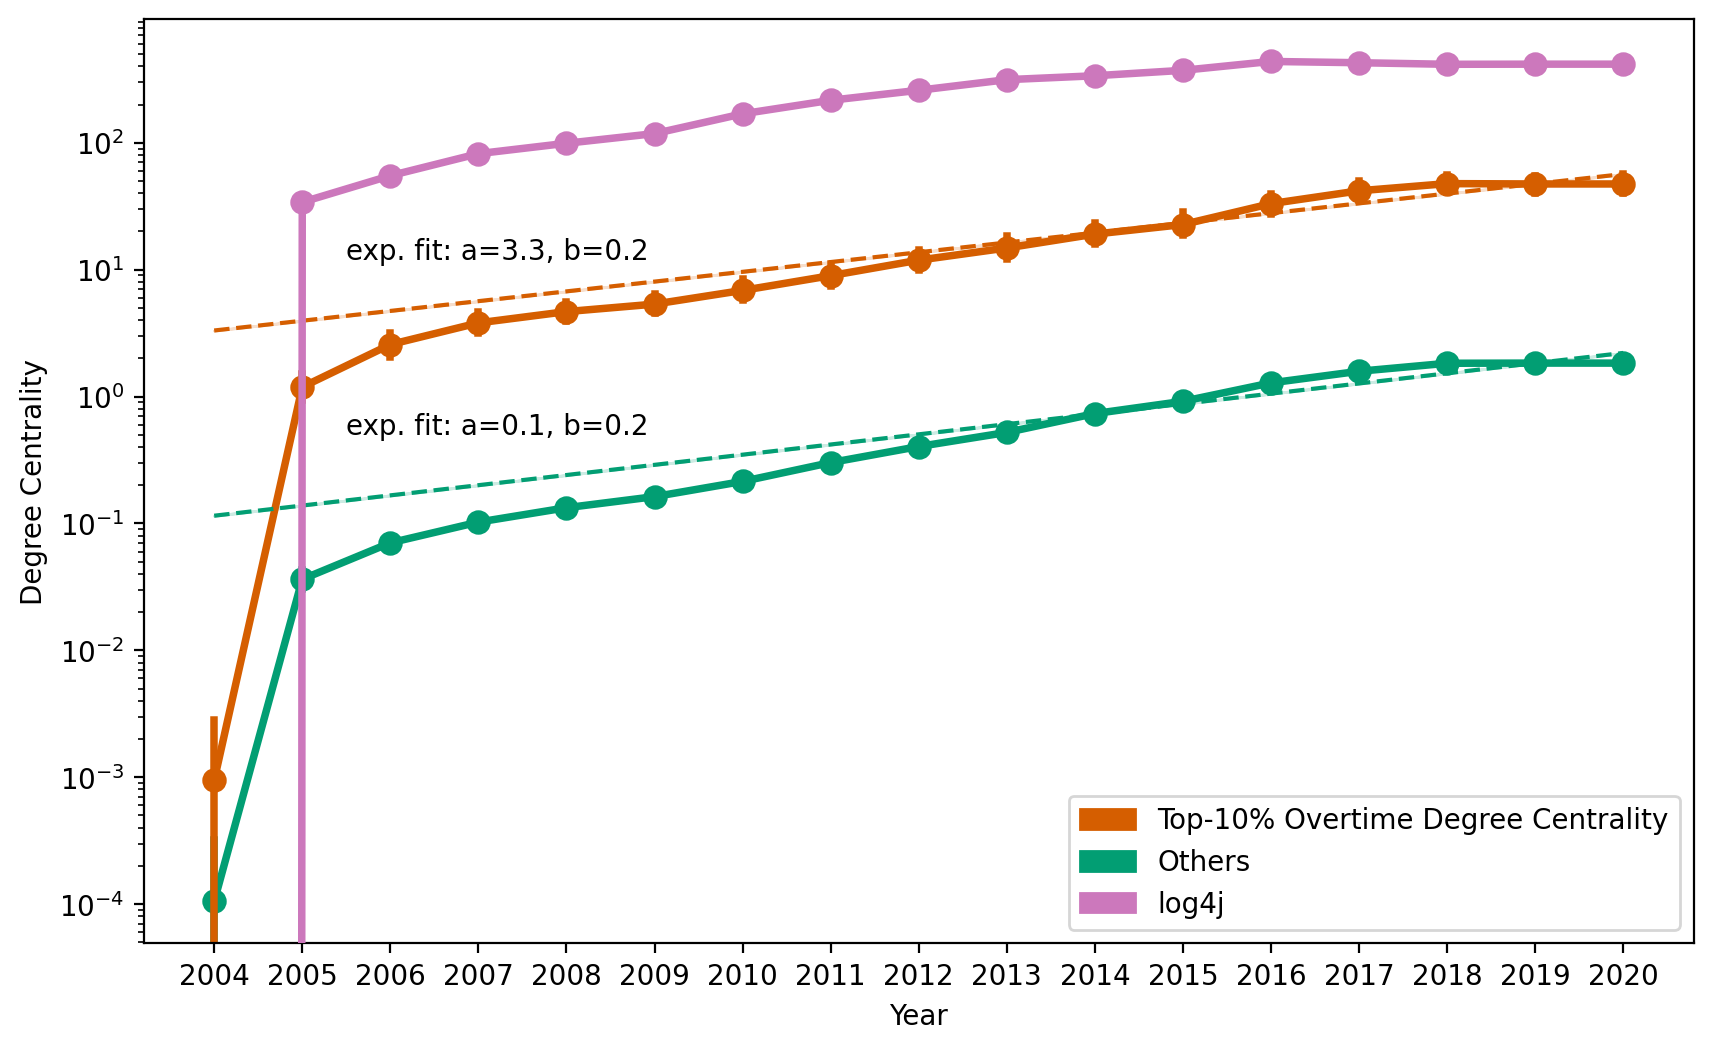

In [75]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':200})


X = pertime.query("hub_tf == 'hub'").t.tolist()
y = pertime.query("hub_tf == 'hub'").degree_centrality.tolist()
pars, cov = curve_fit(f=exponential, xdata=X, ydata=y)
ax = sns.pointplot(pertime, x = "t", y="degree_centrality", hue="hub_tf")
ax = sns.lineplot(x = X, y=[exponential(i, pars[0], pars[1]) for i in X], linestyle="--", color=sns.color_palette("colorblind").as_hex()[3])
ax.text(1.5, 12, f"exp. fit: a={np.round(pars[0],1)}, b={np.round(pars[1],1)}")

X = pertime.query("hub_tf == 'no_hub'").t.tolist()
y = pertime.query("hub_tf == 'no_hub'").degree_centrality.tolist()
pars, cov = curve_fit(f=exponential, xdata=X, ydata=y)
ax = sns.lineplot(x = X, y=[exponential(i, pars[0], pars[1]) for i in X], linestyle="--", color=sns.color_palette("colorblind").as_hex()[2])
ax.text(1.5, 0.5, f"exp. fit: a={np.round(pars[0],1)}, b={np.round(pars[1],1)}")

ax.set_yscale('log')

import matplotlib.patches as mpatches
loss_patch = mpatches.Patch(color=sns.color_palette("colorblind").as_hex()[3], label='Top-10% Overtime Degree Centrality')
ari_patch = mpatches.Patch(color=sns.color_palette("colorblind").as_hex()[2], label='Others')
log_patch = mpatches.Patch(color=sns.color_palette("colorblind").as_hex()[4], label='log4j')
ax.legend(handles=[loss_patch, ari_patch, log_patch], fontsize=10, loc="lower right")

ax.set_xticklabels(list(range(2004, 2021)))

ax.set_xlabel("Year")
ax.set_ylabel("Degree Centrality")

In [52]:
t = pp.TemporalNetwork()

n = 50
temp_ids = np.argpartition(overtime, -n)[-n:]

for i in tqdm(range(len(df_temp))):
    if df_temp['j'][i] in temp_ids:
        t.add_edge(df_temp['i'][i], df_temp['j'][i], int(df_temp['t'][i]))

100%|██████████| 455525/455525 [00:18<00:00, 25233.79it/s]


In [51]:
print(t)

Nodes:			6761
Time-stamped links:	171436
Links/Nodes:		25.356604052654934
Observation period:	[1, 16]
Observation length:	 15 
Time stamps:		 16 
Avg. inter-event dt:	 1.0
Min/Max inter-event dt:	 1/1


In [49]:
style = {    
  'ts_per_frame': 1, 
  'ms_per_frame': 2000,
  'look_ahead': 2, 
  'look_behind': 2, 
  'node_size': 4, 
  'inactive_edge_width': 2,
  'active_edge_width': 4, 
  'label_color' : '#ffffff',
  'label_size' : '2px',
  'label_offset': [0,5],
  'width': 1000,
  'height': 1000
  }

pp.visualisation.export_html(t, 'my_temporal_network_2.html', **style)